# Mount Google Drive to access dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.makedirs('./dataset', exist_ok=True)

!unzip /content/drive/MyDrive/dataset/DeepFake.zip -d ./dataset/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/DeepFake/val/real/829/00177.png  
  inflating: ./dataset/DeepFake/val/real/829/00599.png  
   creating: ./dataset/DeepFake/val/real/840/
  inflating: ./dataset/DeepFake/val/real/840/00058.png  
  inflating: ./dataset/DeepFake/val/real/840/00627.png  
  inflating: ./dataset/DeepFake/val/real/840/00366.png  
  inflating: ./dataset/DeepFake/val/real/840/00362.png  
  inflating: ./dataset/DeepFake/val/real/840/00059.png  
  inflating: ./dataset/DeepFake/val/real/840/00060.png  
  inflating: ./dataset/DeepFake/val/real/840/00526.png  
  inflating: ./dataset/DeepFake/val/real/840/00189.png  
  inflating: ./dataset/DeepFake/val/real/840/00750.png  
  inflating: ./dataset/DeepFake/val/real/840/00552.png  
   creating: ./dataset/DeepFake/val/real/801/
  inflating: ./dataset/DeepFake/val/real/801/00282.png  
  inflating: ./dataset/DeepFake/val/real/801/00283.png  
  inflating: ./dataset/DeepFake/val/real/801/00408.png  
  inflating: ./da

In [3]:
import numpy as np
import random
import glob
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility

In [4]:
# For code reproducibility

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Create custom datasets & dataloaders

In [5]:
class MyData(Dataset):
    def __init__(self, type=0): # type0:train / type1:val / type2:test
      self.img_list = []
      self.label_list = []
      typelist = ['train', 'val', 'test']

      real_dirlist = os.listdir(f'./dataset/DeepFake/{typelist[type]}/real')
      fake_dirlist = os.listdir(f'./dataset/DeepFake/{typelist[type]}/fake')

      for idx in range(len(real_dirlist)):
        img_list = glob.glob(f'./dataset/DeepFake/{typelist[type]}/real/{real_dirlist[idx]}/*.png')
        label_list = [0 for i in range(len(img_list))] # 0: real / 1: fake
        self.img_list += img_list
        self.label_list += label_list
      for idx in range(len(fake_dirlist)):
        img_list = glob.glob(f'./dataset/DeepFake/{typelist[type]}/fake/{fake_dirlist[idx]}/*.png')
        label_list = [1 for i in range(len(img_list))] # 0: real / 1: fake
        self.img_list += img_list
        self.label_list += label_list

      self.train_transform =  transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
      self.test_transform =  transforms.Compose([
                                            transforms.Resize(224),
                                            transforms.ToTensor(),
                                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                            ])
      self.type = type

    def __len__(self):
      return len(self.img_list)

    def __getitem__(self, index):
      img_path = self.img_list[index]
      label = self.label_list[index]
      img = Image.open(img_path).convert('RGB')

      if self.type == 2: # test
        img = self.test_transform(img)
      else: # train, val
        img = self.train_transform(img)

      return img, label

In [6]:
# Generating custom dataset

trainset = MyData(type=0)
valset = MyData(type=1)
testset = MyData(type=2)

print(f"# of train data: {len(trainset)}, # of val data: {len(valset)}, # of test data: {len(testset)}")

# of train data: 15000, # of val data: 2500, # of test data: 2500


In [7]:
# Generating train/val/test dataloader

train_loader = DataLoader(trainset, batch_size=128,
                            num_workers=2, shuffle=True, pin_memory=True)

val_loader = DataLoader(valset, batch_size=128,
                            num_workers=2, shuffle=False, pin_memory=True)

test_loader = DataLoader(testset, batch_size=1,
                            num_workers=2, shuffle=True, pin_memory=True)

# Use timm ResNet18 model

In [8]:
!pip install timm

In [9]:
import timm

model = timm.create_model('resnet18', pretrained=False, num_classes=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train & Validation

In [10]:
# hyperparameter setting

epochs = 64

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
best_acc = 0
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
os.makedirs('./weights', exist_ok=True)
dormant = 0

for epoch in range(epochs):
    avg_train_loss = AverageMeter()
    train_correct = 0
    train_total = 0

    # train
    model.train()
    for idx, i in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}"):
        data_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
        data_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

        out = model(data_x) # torch.tensor, [b, 2]
        pred_y = torch.argmax(out, dim=1) # [b]

        train_total += data_y.shape[0]
        for i in range(data_y.shape[0]):
            if torch.equal(pred_y[i], data_y[i]):
                train_correct += 1

        loss = torch.FloatTensor([0.]).to(device)
        loss += criterion(out, data_y)
        avg_train_loss.update(loss.item(), data_x.shape[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = avg_train_loss.avg
    train_acc = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ----------------------------------------------------------------------------------------
    # Evaluation(Validation set)
    avg_val_loss = AverageMeter()
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for idx, i in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation"):
            val_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 3, 224, 224]
            val_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

            val_out = model(val_x) # torch.tensor, [b, 2]
            val_pred_y = torch.argmax(val_out, dim=1) # [b]

            val_total += val_y.shape[0]
            for j in range(val_y.shape[0]):
                if torch.equal(val_pred_y[j], val_y[j]):
                    val_correct += 1

            val_loss = torch.FloatTensor([0.]).to(device)
            val_loss += criterion(val_out, val_y)
            avg_val_loss.update(val_loss.item(), val_x.shape[0])

    val_loss = avg_val_loss.avg
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if best_acc < val_acc:
        print('\nHigher validation accuracy, saving model weights...')
        print('best acc: {:4f}'.format(best_acc), 'current acc: {:.4f}'.format(val_acc))
        best_acc = val_acc
        torch.save(model,'./weights/best.pt')
        dormant = 0

    if epoch % 1 == 0:
        print("\n[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f" %(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))
    print("★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★")

    dormant += 1
    if dormant == 10:
      print("\nEarly exiting...")
      break

print('Best validation accuracy: {:4f}'.format(best_acc))
print('Training Finished!')

Validation: 100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Higher validation accuracy, saving model weights...
best acc: 0.000000 current acc: 0.5480

[1/64] TrainLoss: 0.622, ValLoss: 0.846 | TrainAcc: 0.64, ValAcc: 0.55
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]



Higher validation accuracy, saving model weights...
best acc: 0.548000 current acc: 0.8100

[2/64] TrainLoss: 0.432, ValLoss: 0.408 | TrainAcc: 0.80, ValAcc: 0.81
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



Higher validation accuracy, saving model weights...
best acc: 0.810000 current acc: 0.8392

[3/64] TrainLoss: 0.274, ValLoss: 0.364 | TrainAcc: 0.88, ValAcc: 0.84
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]



Higher validation accuracy, saving model weights...
best acc: 0.839200 current acc: 0.8776

[4/64] TrainLoss: 0.175, ValLoss: 0.321 | TrainAcc: 0.93, ValAcc: 0.88
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


[5/64] TrainLoss: 0.108, ValLoss: 1.053 | TrainAcc: 0.96, ValAcc: 0.72
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


[6/64] TrainLoss: 0.087, ValLoss: 0.343 | TrainAcc: 0.97, ValAcc: 0.87
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


[7/64] TrainLoss: 0.053, ValLoss: 0.451 | TrainAcc: 0.98, ValAcc: 0.87
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



Higher validation accuracy, saving model weights...
best acc: 0.877600 current acc: 0.9180

[8/64] TrainLoss: 0.044, ValLoss: 0.373 | TrainAcc: 0.98, ValAcc: 0.92
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


[9/64] TrainLoss: 0.039, ValLoss: 0.307 | TrainAcc: 0.99, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


[10/64] TrainLoss: 0.028, ValLoss: 0.375 | TrainAcc: 0.99, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]



Higher validation accuracy, saving model weights...
best acc: 0.918000 current acc: 0.9488

[11/64] TrainLoss: 0.025, ValLoss: 0.221 | TrainAcc: 0.99, ValAcc: 0.95
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


[12/64] TrainLoss: 0.025, ValLoss: 0.256 | TrainAcc: 0.99, ValAcc: 0.93
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


[13/64] TrainLoss: 0.019, ValLoss: 0.212 | TrainAcc: 0.99, ValAcc: 0.93
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


[14/64] TrainLoss: 0.020, ValLoss: 0.382 | TrainAcc: 0.99, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


[15/64] TrainLoss: 0.024, ValLoss: 0.302 | TrainAcc: 0.99, ValAcc: 0.93
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]



Higher validation accuracy, saving model weights...
best acc: 0.948800 current acc: 0.9568

[16/64] TrainLoss: 0.012, ValLoss: 0.208 | TrainAcc: 1.00, ValAcc: 0.96
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


[17/64] TrainLoss: 0.012, ValLoss: 0.363 | TrainAcc: 1.00, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


[18/64] TrainLoss: 0.010, ValLoss: 0.312 | TrainAcc: 1.00, ValAcc: 0.92
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


[19/64] TrainLoss: 0.015, ValLoss: 0.618 | TrainAcc: 1.00, ValAcc: 0.88
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



Higher validation accuracy, saving model weights...
best acc: 0.956800 current acc: 0.9672

[20/64] TrainLoss: 0.021, ValLoss: 0.140 | TrainAcc: 0.99, ValAcc: 0.97
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


[21/64] TrainLoss: 0.011, ValLoss: 0.254 | TrainAcc: 1.00, ValAcc: 0.95
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


[22/64] TrainLoss: 0.010, ValLoss: 0.417 | TrainAcc: 1.00, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


[23/64] TrainLoss: 0.027, ValLoss: 1.289 | TrainAcc: 0.99, ValAcc: 0.74
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


[24/64] TrainLoss: 0.018, ValLoss: 0.270 | TrainAcc: 0.99, ValAcc: 0.94
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


[25/64] TrainLoss: 0.010, ValLoss: 0.969 | TrainAcc: 1.00, ValAcc: 0.81
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


[26/64] TrainLoss: 0.006, ValLoss: 0.295 | TrainAcc: 1.00, ValAcc: 0.92
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


[27/64] TrainLoss: 0.006, ValLoss: 0.202 | TrainAcc: 1.00, ValAcc: 0.95
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



Higher validation accuracy, saving model weights...
best acc: 0.967200 current acc: 0.9732

[28/64] TrainLoss: 0.005, ValLoss: 0.140 | TrainAcc: 1.00, ValAcc: 0.97
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


[29/64] TrainLoss: 0.004, ValLoss: 0.180 | TrainAcc: 1.00, ValAcc: 0.97
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


[30/64] TrainLoss: 0.003, ValLoss: 0.186 | TrainAcc: 1.00, ValAcc: 0.97
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


[31/64] TrainLoss: 0.003, ValLoss: 0.188 | TrainAcc: 1.00, ValAcc: 0.96
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


[32/64] TrainLoss: 0.004, ValLoss: 0.409 | TrainAcc: 1.00, ValAcc: 0.92
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


[33/64] TrainLoss: 0.004, ValLoss: 0.466 | TrainAcc: 1.00, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


[34/64] TrainLoss: 0.031, ValLoss: 0.702 | TrainAcc: 0.99, ValAcc: 0.86
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


[35/64] TrainLoss: 0.040, ValLoss: 0.214 | TrainAcc: 0.99, ValAcc: 0.96
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


[36/64] TrainLoss: 0.007, ValLoss: 0.185 | TrainAcc: 1.00, ValAcc: 0.96
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


[37/64] TrainLoss: 0.004, ValLoss: 0.178 | TrainAcc: 1.00, ValAcc: 0.96
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Early exiting...
Best validation accuracy: 0.973200
Training Finished!


# Visualize loss & accuracy

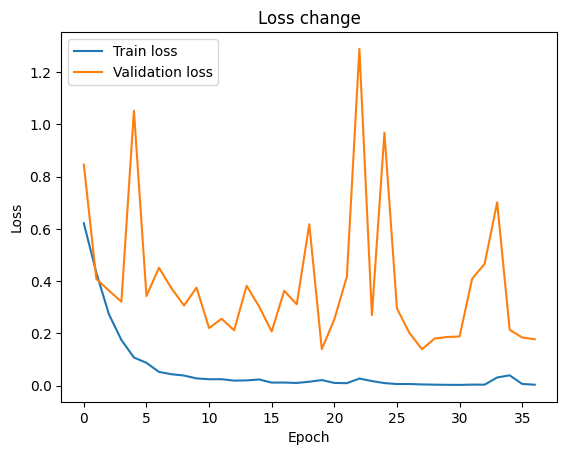

In [13]:
# Visualize loss change

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

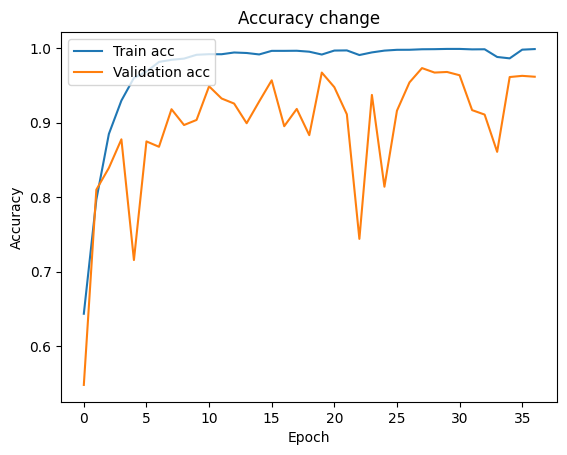

In [14]:
# Visualize accuracy change

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Accuracy change')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')
plt.show()

# Testing result & visualization

In [15]:
# Load saved model

testmodel = torch.load('./weights/best.pt')
print("Model is successfully loaded!")

Model is successfully loaded!


<ipython-input-15-3e996cf6f694>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('./weights/best.pt')


Testing...


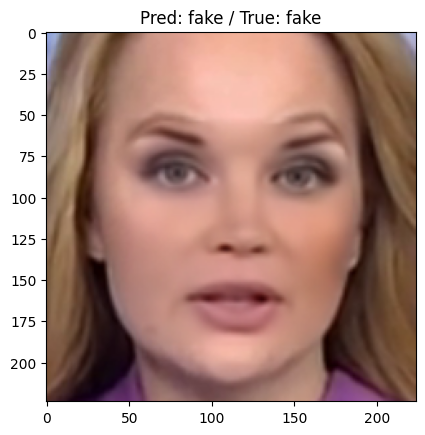

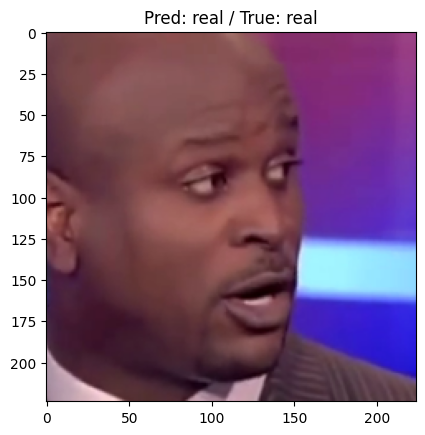

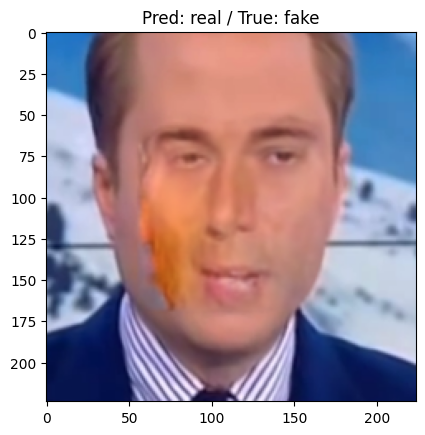

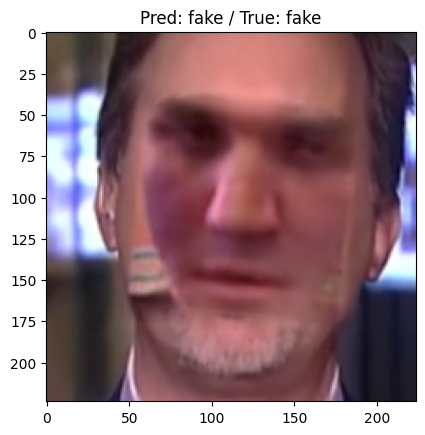

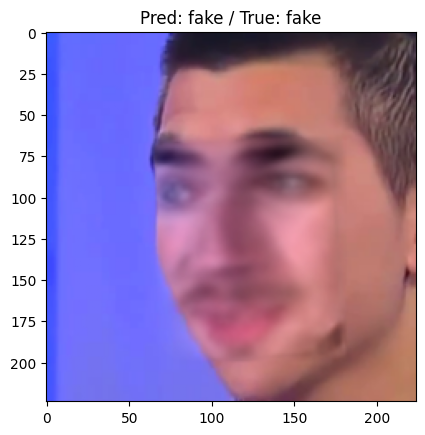

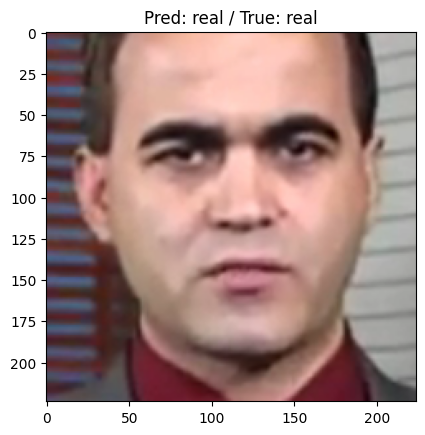

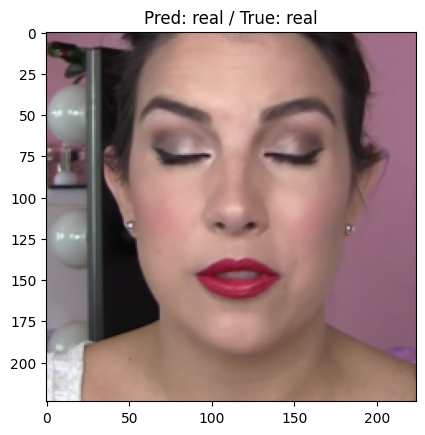

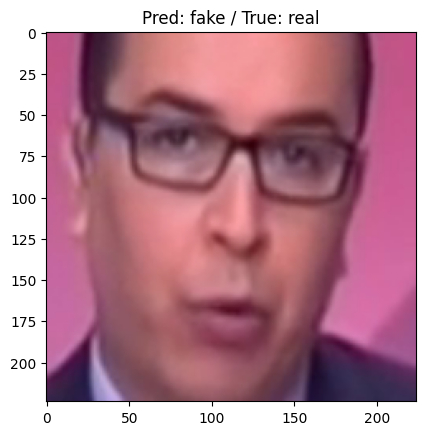

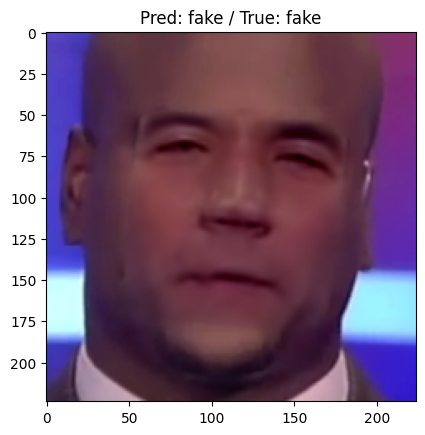


Test accuracy: 0.96


In [16]:
# Checking test accuracy & Visualization

test_correct = 0
test_total = 0
classes = ['real', 'fake']

testmodel.eval()
print("Testing...")
with torch.no_grad():
    for idx, i in enumerate(test_loader):
        test_x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(i[0])
        test_x = test_x.type(torch.float32).to(device) # torch.tensor, [1, 3, 224, 224]
        test_y = i[1].type(torch.int64).to(device) # torch.tensor, [1]

        test_out = testmodel(test_x) # torch.tensor, [1, 2]
        test_pred_y = torch.argmax(test_out, dim=1) # [1]

        test_total += test_y.shape[0]
        for k in range(test_y.shape[0]):
            if torch.equal(test_pred_y, test_y):
                test_correct += 1

        # Visualization of test results
        if idx % 300 == 0:
          img = i[0].squeeze().permute(1,2,0).detach().cpu().numpy()
          plt.imshow(np.clip(img,0,1))
          plt.title(f"Pred: {classes[test_pred_y.detach().cpu().numpy()[0]]} / True: {classes[test_y.detach().cpu().numpy()[0]]}")
          plt.show()

test_acc = test_correct / test_total
print("\nTest accuracy: %.2f" %(test_acc))